In [1]:
import numpy as np
import random
import numpy.linalg as la
import matplotlib.pyplot as plt
import math
from collections import Counter
from typing import List



def chain_builder(N, rho):
    """
    having chain be a numpy array that the first column is the ferminonic number of the pair and the second column 
    is the Majorana operator which can be assigned randomly at contact to simulate quantum randomness.
    third column is the pair index
    """
    if N % 2 != 0:
        raise ValueError("N must be even for a Majorana chain.")
    chain = np.empty((N * rho, 3), dtype=object)
    for i in range(N):
        chain[i * rho][0] = 1 # initially all pairs have fermion number 1
        chain[i * rho][1] = True
        chain[i * rho][2] = int(i/2) # index for pair (i,j), where i<j, using i to denote the Majorana j is paired with.
    return chain

def hopping_annihilate(chain):
    N = len(chain)
    index = np.where(chain[:,1]==True)[0] # get the index of Majorana operators
    i =random.choice(index) # choose a random Majorana operator to hop
    
    hope_direction = random.choice([-1, 1])
    if  chain[:, 2].tolist().count(None) == N: #if all sites are empty

        return chain, 0
    if chain[i][0] == None: #if the site is empty
        pass

    elif chain[(i+hope_direction) % N][0] == None: #if the site to arrive is empty
        chain[(i+hope_direction) % N][0] = chain[i][0]
        chain[i][0] = None
        chain[(i+hope_direction) % N][1] = chain[i][1]
        chain[i][1] = None
        chain[(i+hope_direction) % N][2] = chain[i][2]
        chain[i][2] = None
        pass

    elif chain[(i+hope_direction) % N][2] == chain[i][2]:  #if paired under periodic boundary condition
        if chain[i][0] == 0 and chain[(i+hope_direction) % N][0] == 0:
            chain[i][0] = None
            chain[(i+hope_direction) % N][0] = None
            chain[i][1] = None
            chain[(i+hope_direction) % N][1] = None
            chain[i][2] = None
            chain[(i+hope_direction) % N][2] = None
    
        elif chain[i][0] != 0 and chain[(i+hope_direction) % N][0] != 0:
        
        
            # get the index of paired Majorana
            rows_i = np.where(chain[:, 2] == chain[i][2])[0]
            rows = np.where(chain[:, 2] == chain[(i+hope_direction) % N][2])[0]
            outside_index_i = [x for x in rows_i if x != i][0]
            outside_index = [x for x in rows if x != (i+hope_direction)%N][0]

            # calculate the ferminon number of new arcs
            chain[i][1] = random.choice([0, 1])
            chain[(i+hope_direction) % N][1] = random.choice([0, 1])
            n_sum = chain[i][0] + chain[(i+hope_direction) % N][0]
            ferminon_number = (chain[i][1] + chain[(i+hope_direction) % N][1]) % 2
            
            if ferminon_number == 0:
                chain[i][0] = None
                chain[(i+hope_direction) % N][0] = None
                chain[i][1] = None
                chain[(i+hope_direction) % N][1] = None
                chain[i][2] = None
                chain[(i+hope_direction) % N][2] = None
                chain[outside_index_i][0] = None
                chain[outside_index][0] = None
                chain[outside_index_i][1] = None
                chain[outside_index][1] = None
                chain[outside_index_i][2] = None
                chain[outside_index][2] = None

            else:
                chain[i][0] = ferminon_number
                chain[(i+hope_direction) % N][0] = ferminon_number
                chain[outside_index_i][0] = (n_sum-ferminon_number) % 2 # conservation of ferminon number
                chain[outside_index][0] = (n_sum-ferminon_number) % 2

                # update the pairing index
                
                pair_index = chain[(i+hope_direction) % N][2]
                pair_index_i = chain[i][2]
                min_index = min(pair_index, pair_index_i)
                max_index = max(pair_index, pair_index_i)

                if  i == min(i, (i+hope_direction) % N, outside_index_i, outside_index) or (i+hope_direction) % N == min(i, (i+hope_direction) % N, outside_index_i, outside_index):
                    chain[i][2] = min_index
                    chain[(i+hope_direction) % N][2] = min_index
                    chain[outside_index_i][2] = max_index
                    chain[outside_index][2] = max_index
                else:
                    chain[i][2] = max_index
                    chain[(i+hope_direction) % N][2] = max_index
                    chain[outside_index_i][2] = min_index
                    chain[outside_index][2] = min_index
            """       
            else:
                
                # get the index of pairing Majorana
                rows, cols = np.where(chain == chain[i][2])
                rows_right, cols_left = np.where(chain == chain[(i+hope_direction) % N][2])
                outside_index = [x for x in rows if x != i][0]
                right_outside_index = [x for x in rows_right if x != (i+hope_direction)%N][0]

                # calculate the ferminon number of new arcs
                chain[i][1] = np.random.choice([0, 1])
                chain[(i+hope_direction) % N][1] = np.random.choice([0, 1])
                ferminon_number = (chain[i][1] + chain[(i+hope_direction) % N][1]) %2
                
                chain[i][0] = ferminon_number
                chain[(i+hope_direction) % N][0] = ferminon_number
                chain[outside_index][0] = (ferminon_number+1) % 2 # conservation of ferminon number
                chain[right_outside_index][0] = (ferminon_number+1) % 2

                # update the pairing index
                pair_index_right = chain[(i+hope_direction) % N][2]
                pair_index_left = chain[i][2]
                if  i == min(i, (i+hope_direction) % N, outside_index, right_outside_index) or (i+hope_direction) % N == min(i, (i+hope_direction) % N, outside_index, right_outside_index):
                    chain[i][2] = pair_index_left
                    chain[(i+hope_direction) % N][2] = pair_index_left
                    chain[outside_index][2] = pair_index_right
                    chain[right_outside_index][2] = pair_index_right
                else:
                    chain[i][2] = pair_index_right
                    chain[(i+hope_direction) % N][2] = pair_index_right
                    chain[outside_index][2] = pair_index_left
                    chain[right_outside_index][2] = pair_index_left

            """
    density = N - chain[:,2].tolist().count(None)  # Count the number of empty sites
    return chain, density
    

def evolution_annihilate(chain, t):
    """
    Simulates the evolution of the Majorana chain over time t.
    The function modifies the chain in place.
    """
    density = []
    times = [i for i in range(t)]
    for _ in range(t):
        
        chain, x = hopping_annihilate(chain)
        density.append(x)
    return times, density

def calculate_pair_distances(chain):
    """
    Computes the arc length of Majorana pairs
    
    Returns:
      pair_data: a list of tuples (pair_index, distance)
      distance_counts: a dictionary mapping distance -> count of pairs with that distance
    """
    pair_positions = {}
    # Loop over each row in the chain and record its index based on its pairing index (third column)
    for i, row in enumerate(chain):
        pair_idx = row[2]
        if pair_idx is None:
            pass
        if pair_idx in pair_positions:
            pair_positions[pair_idx].append(i)
        else:
            pair_positions[pair_idx] = [i]
    
    pair_data = []    
    distance_counts = {} 
    
    for pair_idx, positions in pair_positions.items():
        if len(positions) == 2:
            d = abs(positions[1] - positions[0])
            pair_data.append((pair_idx, d))
            distance_counts[d] = distance_counts.get(d, 0) + 1
        else:
            # If there are not exactly two entries for a pair index, issue a warning.
            print(f"Warning: Pair index {pair_idx} appears {len(positions)} times (expected 2).")
    
    return pair_data, distance_counts
     

def S_A(chain, R):
    """
    Count “whole” and “half” pairs in lst[start:end].

    - If both occurrences of a value fall inside [start,end), it contributes 1.
    - If exactly one occurrence falls inside, it contributes 0.5.
    """
    S_A_ = 0.0
    start = (len(chain)-R)//2
    end = start + R -1
    window = chain[start:end,2]
    cnt = Counter(window)
    S_A_ = sum(min(c, 2) * 0.5 for c in cnt.values())
    return S_A_



In [4]:
def hopping_annihilate(chain):
    N = len(chain)
     # get the index of Majorana operators
   
    # i =random.randint(0, N-1)
    index = np.where(chain[:,1]==True)[0]
    for i in index:
        
        hope_direction = random.choice([-1, 1])
        if  chain[:, 2].tolist().count(None) == N: #if all sites are empty

            return chain, 0
        if chain[i][0] == None: #if the site is empty
            pass

        elif chain[(i+hope_direction) % N][0] == None: #if the site to arrive is empty
            chain[(i+hope_direction) % N][0] = chain[i][0]
            chain[i][0] = None
            chain[(i+hope_direction) % N][1] = chain[i][1]
            chain[i][1] = None
            chain[(i+hope_direction) % N][2] = chain[i][2]
            chain[i][2] = None
            pass

        elif chain[(i+hope_direction) % N][2] == chain[i][2]:  #if paired under periodic boundary condition
            if chain[i][0] == 0 and chain[(i+hope_direction) % N][0] == 0:
                chain[i][0] = None
                chain[(i+hope_direction) % N][0] = None
                chain[i][1] = None
                chain[(i+hope_direction) % N][1] = None
                chain[i][2] = None
                chain[(i+hope_direction) % N][2] = None
        
            elif chain[i][0] != 0 and chain[(i+hope_direction) % N][0] != 0:
            
            
                # get the index of paired Majorana
                rows_i = np.where(chain[:, 2] == chain[i][2])[0]
                rows = np.where(chain[:, 2] == chain[(i+hope_direction) % N][2])[0]
                outside_index_i = [x for x in rows_i if x != i][0]
                outside_index = [x for x in rows if x != (i+hope_direction)%N][0]

                # calculate the ferminon number of new arcs
                ferminon_number = random.choice([0, 1])
                chain[(i+hope_direction) % N][1] = random.choice([0, 1])
                n_sum = chain[i][0] + chain[(i+hope_direction) % N][0]
                # ferminon_number = (chain[i][1] + chain[(i+hope_direction) % N][1]) % 2
                
                if ferminon_number == 0:
                    chain[i][0] = None
                    chain[(i+hope_direction) % N][0] = None
                    chain[i][1] = None
                    chain[(i+hope_direction) % N][1] = None
                    chain[i][2] = None
                    chain[(i+hope_direction) % N][2] = None
                else:
                    chain[i][0] = ferminon_number
                    chain[(i+hope_direction) % N][0] = ferminon_number
                    chain[outside_index_i][0] = (n_sum-ferminon_number) % 2 # conservation of ferminon number
                    chain[outside_index][0] = (n_sum-ferminon_number) % 2

                    # update the pairing index
                    
                    pair_index = chain[(i+hope_direction) % N][2]
                    pair_index_i = chain[i][2]
                    min_index = min(pair_index, pair_index_i)
                    max_index = max(pair_index, pair_index_i)

                    if  i == min(i, (i+hope_direction) % N, outside_index_i, outside_index) or (i+hope_direction) % N == min(i, (i+hope_direction) % N, outside_index_i, outside_index):
                        chain[i][2] = min_index
                        chain[(i+hope_direction) % N][2] = min_index
                        chain[outside_index_i][2] = max_index
                        chain[outside_index][2] = max_index
                    else:
                        chain[i][2] = max_index
                        chain[(i+hope_direction) % N][2] = max_index
                        chain[outside_index_i][2] = min_index
                        chain[outside_index][2] = min_index
                
    density = N - chain[:,2].tolist().count(None)  # Count the number of empty sites
    return chain, density
    

In [5]:
chain = chain_builder(10000, 4)
# print(np.where(chain[:, 1] == True)[0])
# print(500 - chain[:,2].tolist().count(None))
times, density = evolution_annihilate(chain, t =40000)

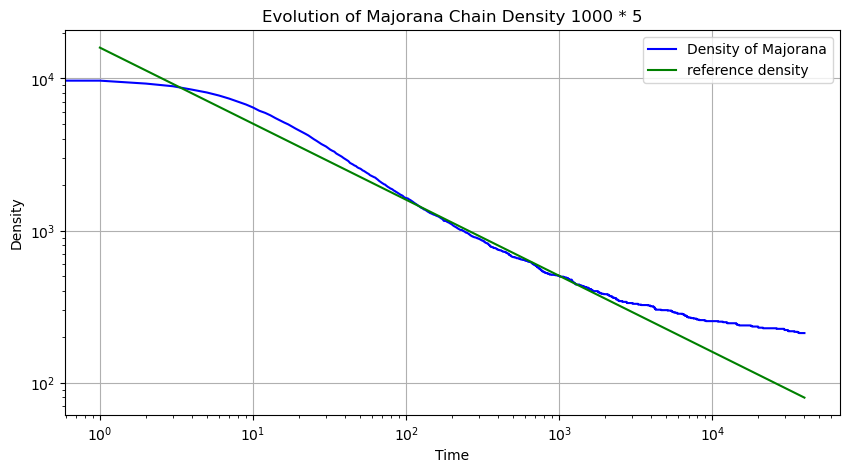

In [10]:
dens =  np.array(density)/ 40000
tim = np.array(times)
density_ref = 40000/(np.sqrt(2 * np.pi* tim[1:])) 
const =  dens * np.sqrt(2 * np.pi * tim)
plt.figure(figsize=(10, 5))
# plt.plot(times, density, label='Density of Majorana', color='blue')
plt.plot(times, density, label='Density of Majorana', color='blue')
plt.xscale('log')
plt.yscale('log')
# plt. plot(times, const, label='rho * sqrt(8 * pi * t)', color='red')
plt.plot(times[1:], density_ref, label='reference density', color='green')

plt.xlabel('Time')
plt.ylabel('Density')
plt.title('Evolution of Majorana Chain Density 1000 * 5')
# plt.xlim(0,6)
plt.legend()
plt.grid()
plt.show()

In [23]:
density = np.array(density)/ 40000
(np.log(density[100]) - np.log(density[1000]))/(np.log(1000)- np.log(100))

0.5118833609788758

In [54]:
from scipy.optimize import curve_fit
def density_func(x, a):
    f = 1e-10
    return a/ (np.sqrt(x)+f) #** (-1)
    # return a * np.exp(-x) 
    # return a * np.sqrt(x)
times1 = np.array(times)
density1 = np.array(density)/500

def const_func(x, a):
    # return a * np.sqrt( x)
    return a * x 

np.delete(times1, 0)
np.delete(density1, 0)

popt, pcov = curve_fit(density_func, times1, density1)
popt1, pcov1 = curve_fit(const_func, times1, const)
print("Fitted parameter:", popt)
print("Covariance of the parameters:", pcov)
print("Fitted parameter for const:", popt1)
print("Covariance of the parameters for const:", pcov1)



Fitted parameter: [2.00000001e-11]
Covariance of the parameters: [[1.00416089e-24]]
Fitted parameter for const: [0.00021538]
Covariance of the parameters for const: [[4.67920788e-14]]


In [185]:
1/math.sqrt(2 * math.pi) 

0.3989422804014327